# **MNIST Handwritten Digits Classification**

## **Introduction**

The **MNIST dataset** is a classic benchmark in the world of Machine Learning and Deep Learning. It consists of **handwritten digits** ranging from **0 to 9**, spread across **60,000 training samples** and **10,000 test samples**. Each image is a **28x28** grayscale pixel grid, making it a simple and powerful starting point for understanding neural networks. Despite its age, MNIST remains an excellent playground for experimenting with image classification techniques and building foundational knowledge.

In this project, the goal is to **build and evaluate a neural network capable of accurately classifying these handwritten digits**. Starting from scratch, I'll walk through the key steps of any machine learning project:
1. **Data Exploration**: Understanding what the MNIST dataset looks like and uncovering insights about its structure.
2. **Data Preprocessing**: Preparing the data so our model can make sense of it.
3. **Model Design**: Constructing a simple yet effective feedforward neural network with PyTorch to tackle the classification task.
4. **Training and Evaluation**: Teaching our model to recognize digits and measuring how well it performs on unseen data.
5. **Visualization**: Bringing the results to life with visual representations.

---
## **Importing Libraries**

In [100]:
import torch
import torchvision
from torchvision        import transforms
from torch.utils.data   import DataLoader
from torch              import nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from IPython.display    import clear_output
from itertools          import islice

In [101]:
np.random.seed(24)
torch.manual_seed(24)
clear_output()

---
## **Data Loading and Exploration**

In [102]:
basepath = '/content/drive/My Drive/ML Projects/Handwritten Digits'

Load the MNIST dataset for both training and testing splits. The `torchvision.datasets.MNIST` class makes this simple:

In [103]:
train_dataset = torchvision.datasets.MNIST(
    root=basepath, train=True, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root=basepath, train=False, download=True
)

clear_output()

To better understand the data format, I'll extract and print a single sample from the training dataset.

In [104]:
sample = next(iter(train_dataset))
print(sample) # sample = (image, label)

(<PIL.Image.Image image mode=L size=28x28 at 0x7FAC2B55DF30>, 5)


Each sample consists of an 28x28 grayscale image (as a PIL Image) and its corresponding label, 5 in this case.

In the following code, I display the first 10 images from the training set along with their labels. This helps us get a quick visual sense of the handwritten digits.

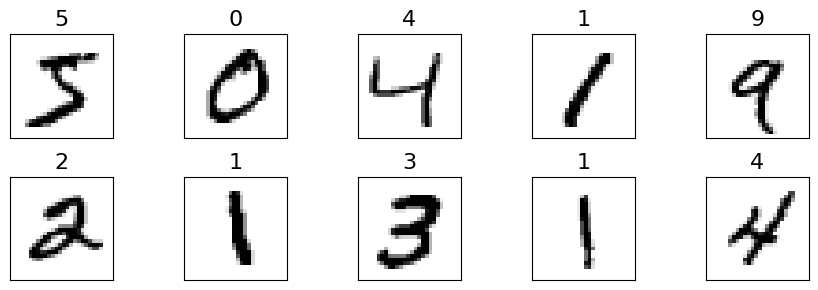

In [105]:
fig = plt.figure(figsize=(9, 3))
for i, (image, label) in islice(enumerate(train_dataset), 10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}', size=16)
plt.tight_layout()
plt.show()

From the visualization, we can see a diverse set of digits. The images are clear, well-centered, and vary slightly in handwritten style.

Next, I focus on a specific digit —in this case, 8. I extract 16 examples of the digit from the training dataset and display them in a grid. This step helps us observe variations in how the same digits is written.

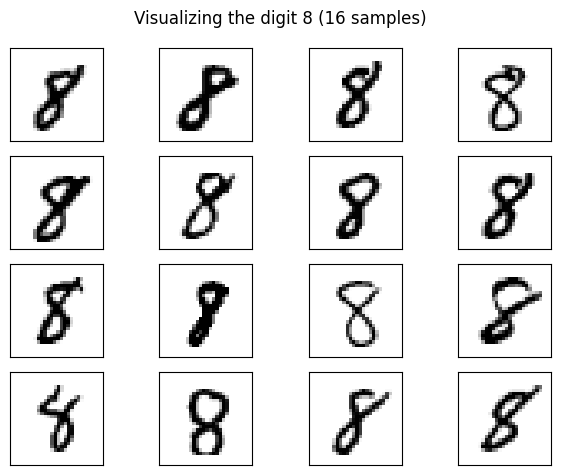

In [106]:
target_number = 8
num_samples = 16
filtered_samples = [image for (image, label) in train_dataset
                    if label == target_number]
selected_samples = islice(filtered_samples, num_samples)

fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=True, sharey=True)
fig.suptitle(f'Visualizing the digit {target_number} '
             f'({num_samples} samples)')
for ax, image in zip(axes.flat, selected_samples):
    ax.imshow(image, cmap='gray_r')
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

We can notice that while all the images represent the digit 8, there are significant variations in handwritten style, thickness, and slant.

Let's check the number of samples in both the training and testing sets to confirm the dataset sizes.

In [107]:
print(f'Training samples: {len(train_dataset)}\n'
      f'Testing samples: {len(test_dataset)}')

Training samples: 60000
Testing samples: 10000


Finally, I'll analyze the distribution of digits in the training set. By counting the occurrences of each label, we can verify whether the dataset is balanced, which is something important for the learning.

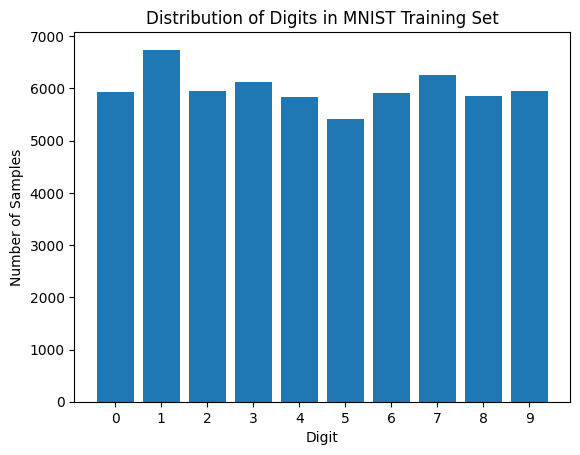

In [108]:
targets = train_dataset.targets.numpy()
counts = np.bincount(targets)

plt.bar(np.arange(10), counts)
plt.xticks(np.arange(10))
plt.xlabel('Digit')
plt.ylabel('Number of Samples')
plt.title('Distribution of Digits in MNIST Training Set')
plt.show()

From the bar chart, we can see that the MNIST dataset is relatively balanced, with each digit appearing roughly the same number of times (around 6,000 samples per digit). This balance ensures that the model won't be biased toward any particular class.

---
## **Data Preprocessing**

To prepare the data for training, I apply the `ToTensor` transformation using `torchvision.transforms`. The `ToTensor` method performs two tasks:
1. Converts the images from PIL format into floating-point tensors.
2. Normalizes the pixel values from the range [0, 255] to the range [0, 1]. This ensures consistency and accelerates model training.

In [109]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# Reload the data applying the transformation
train_dataset = torchvision.datasets.MNIST(
    root=basepath, train=True,
    transform=transform, download=False
)
test_dataset = torchvision.datasets.MNIST(
    root=basepath, train=False,
    transform=transform, download=False
)

clear_output()

Confirm that the transformation was applied correctly:

In [110]:
# Verifying the transformation
print(f'Train data type: {type(train_dataset[0][0])}')
print(f'Test data type: {type(test_dataset[0][0])}')

Train data type: <class 'torch.Tensor'>
Test data type: <class 'torch.Tensor'>


I'll now inspect the shape of a sample image tensor to understand its dimensions.

In [111]:
# Checking the image shape
print(f'Shape of an image tensor: {train_dataset[0][0].shape}')

Shape of an image tensor: torch.Size([1, 28, 28])


`28 x 28` represent the height and width of the image in pixels. The `1` indicates that the images are grayscale. Grayscale has only one channel, representing the intensity of gray at each pixel. If the images were RGB, this dimension would be 3.

---
## **Model Design**

Here is a visual representation of the model I'll implement. It is a very common structure for this kind of problem.

<div>
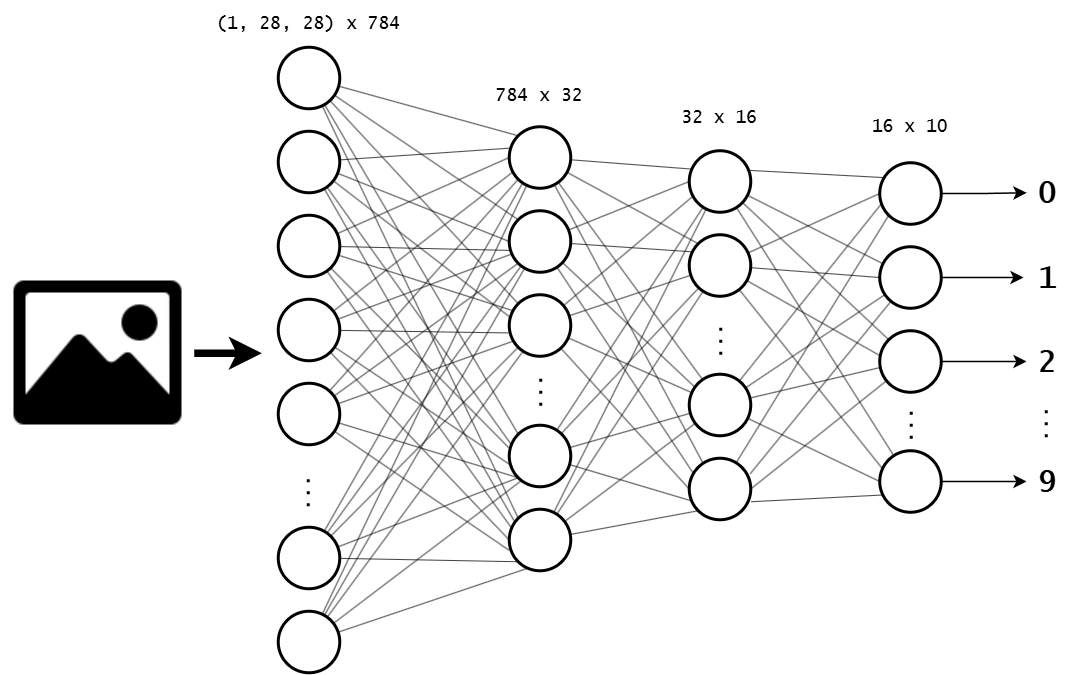
</div>

As we can see, it is a simple feedforward network with three fully connected (linear) layers. The input is a flattened image (1x28x28 becomes 784), which is then passed through two hidden layers with 32 and 16 units, respectively. Finally, the output layer has 10 neurons, corresponding to the 10 possible digit classes. I'll use ReLU activation after each hidden layer to introduce non-linearity, which is crucial for learning complex patterns.

Next, let's define some key parameters based on the dataset.

In [112]:
# Extract the shape of a single image from the training set
image_size = train_dataset[0][0].shape
# Calculate the total number of input features
input_size = image_size[0] * image_size[1] * image_size[2]
output_size = 10 # 0, 1, 2, ..., 9

Here I define the neural network model using PyTorch's `nn.Module`

In [113]:
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.hidden1 = nn.Linear(input_size, 32)
        self.relu1   = nn.ReLU()
        self.hidden2 = nn.Linear(32, 16)
        self.relu2   = nn.ReLU()
        self.output  = nn.Linear(16, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.hidden2(x)
        x = self.relu2(x)
        x = self.output(x)
        return x

In [114]:
model = Model(input_size, output_size)
print(model)

Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): ReLU()
  (hidden2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=16, out_features=10, bias=True)
)


Let's perform one single forward to a dummy sample and see the output

In [115]:
# Generate a single input example
x = torch.randn(1, 1, 28, 28)  # Simulate a single image of size (1, 28, 28)

# Forward pass
output = model(x)
print(output)

tensor([[ 0.1193, -0.0744,  0.1329,  0.1121,  0.2544, -0.0263, -0.0297,  0.0548,
          0.2316, -0.0136]], grad_fn=<AddmmBackward0>)


These are raw logits. Later I'll use the <tt>CrossEntropyLoss</tt> which gets the probabilities.

In [116]:
# Convert logits to probabilities using Softmax
probabilities = torch.softmax(output, dim=1)
print("\nOutput probabilities:")
print(probabilities)


Output probabilities:
tensor([[0.1038, 0.0855, 0.1052, 0.1031, 0.1188, 0.0897, 0.0894, 0.0973, 0.1161,
         0.0909]], grad_fn=<SoftmaxBackward0>)


During training with <tt>CrossEntropyLoss</tt>, Softmax is implicit, so we do not need to include it in the network.

---
## **Training Setup**

Here I define how many samples are processed at a time during training via the `batch_size` parameter. Setting it to, for example, 64 means we'll update the model's weights after processing 64 images. Then I create the `DataLoader` for the training dataset. This handles batching, shuffling, and parallel data loading.

In [117]:
batch_size = 64
train_dl = DataLoader(train_dataset,
                      batch_size, shuffle=True)
print(f"Number of batches per epoch: {len(train_dl)}")

Number of batches per epoch: 938


After that, I define the number of training epochs. An epoch is one complete pass through the entire training dataset. Then I define the learning rate (the learning rate of 0.001 is a reasonable starting point and might be adjusted later if necessary), the loss function using *Cross Entropy*, which is commonly used for multi-class classification, and the optimizer with *Adam*, a popular optimizer that adapts the learning rate for each parameter. It often performs well in practice and is a good default choice.

In [118]:
num_epochs = 20

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to track training accuracy and loss history
train_acc_hist = [0.] * num_epochs
train_loss_hist = [0.] * num_epochs

---
## **Training the Model**

Let's execute the training process:

In [119]:
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss_hist[epoch] += loss.item()

        corrects = (
            torch.argmax(pred, dim=1) == y_batch
        ).float()
        train_acc_hist[epoch] += corrects.mean()
    train_acc_hist[epoch] /= len(train_dl)
    print(f'Epoch {epoch}  Accuracy: '
          f'{train_acc_hist[epoch]:.4f}')

Epoch 0  Accuracy: 0.8571
Epoch 1  Accuracy: 0.9316
Epoch 2  Accuracy: 0.9437
Epoch 3  Accuracy: 0.9529
Epoch 4  Accuracy: 0.9578
Epoch 5  Accuracy: 0.9614
Epoch 6  Accuracy: 0.9654
Epoch 7  Accuracy: 0.9680
Epoch 8  Accuracy: 0.9698
Epoch 9  Accuracy: 0.9717
Epoch 10  Accuracy: 0.9725
Epoch 11  Accuracy: 0.9746
Epoch 12  Accuracy: 0.9754
Epoch 13  Accuracy: 0.9770
Epoch 14  Accuracy: 0.9775
Epoch 15  Accuracy: 0.9793
Epoch 16  Accuracy: 0.9803
Epoch 17  Accuracy: 0.9807
Epoch 18  Accuracy: 0.9820
Epoch 19  Accuracy: 0.9821


**Observations**

-  The training accuracy steadily  increases from 0.85 in the first epoch to 0.98 in the 19th epoch. This indicates that the model is successfully learning to classify the handwritten digits in the training data.
-  The model seems to be converging well, with the accuracy plateauing slightly after epoch 18, which suggests that the model has learned the main patterns in the data and may not benefit significantly from further training on this specific dataset.

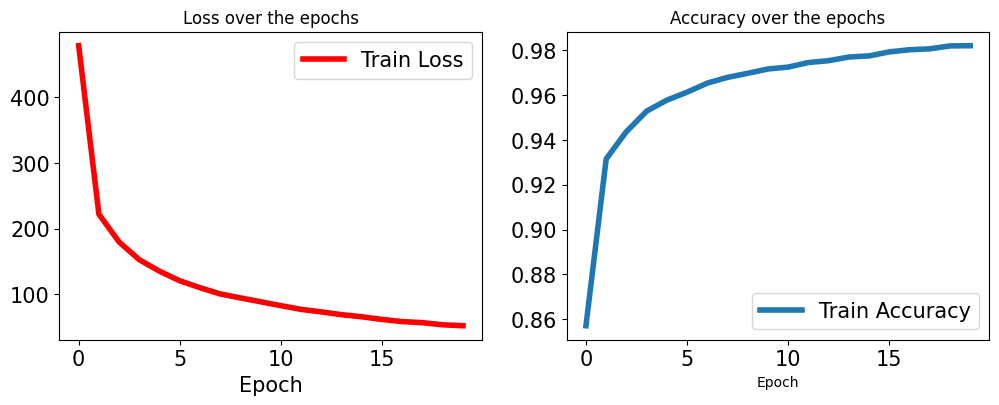

In [120]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(train_loss_hist, lw=4, color='red')
plt.legend(['Train Loss'], fontsize=15)
plt.title('Loss over the epochs')
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(train_acc_hist, lw=4)
plt.legend(['Train Accuracy'], fontsize=15)
plt.title('Accuracy over the epochs')
ax.set_xlabel('Epoch')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

-  The training loss plot shows a clear downward trend across epochs. This is expected behavior as the model learns and reduces its error on the training data. The loss curve seems to be flattening around epoch 18, which aligns with the observation from the accuracy data.
-  The training accuracy plot confirms the steady increase in accuracy throughout the training process. It appears to be approaching an asymptote around epoch 18, suggesting the model's performance is saturating on the training data.

---
## **Model Evaluation**

In [121]:
final_preds = model(test_dataset.data / 255.)
corrects = (
    torch.argmax(final_preds, dim=1) == test_dataset.targets
).float()

print(f'Test Accuracy: {corrects.mean():.4f}')

Test Accuracy: 0.9666


The model achieves a test accuracy of 96%, which is quite good. This indicates that the model has successfully learned to classify handwritten digits and generalizes reasonably well to unseen data.

We can observe that the test accuracy is slightly lower than the final training accuracy. This is expected as the model hasn't seen the test data before and may encounter slightly different patterns compared to the training data. However, the difference isn't significant, suggesting the model is not severely overfitting the training data.


---
## **Visualization**

In this section let's try to get a better visualization of the classification.

To begin, I'll identify 5 test cases where the model is **highly confident but incorrect**. Confidence is measured by the maximum probability predicted for a class. I'll filter predictions where the confidence is high (e.g., above 0.8) but the prediction is not equal to the true label. Then, we'll visualize these cases to understand where the model goes wrong.

In [122]:
import torch.nn.functional as F

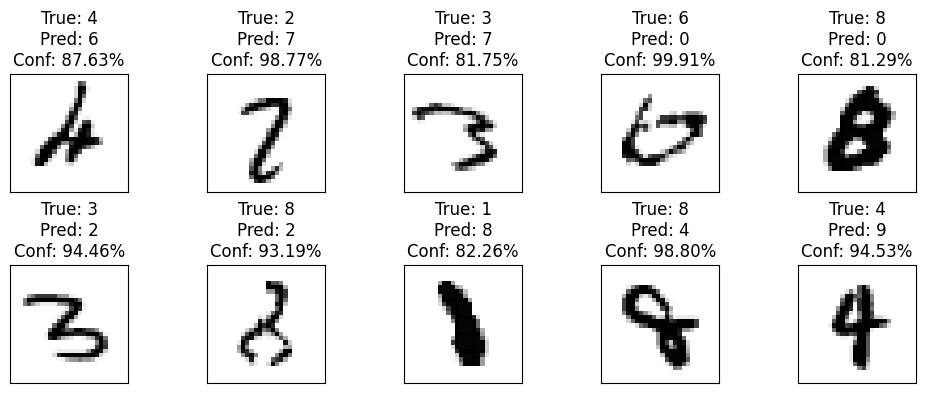

In [123]:
# Convert logits to probabilities
preds = F.softmax(final_preds, dim=1)

# Find incorrect predictions with high confidence
confidences, pred_labels = torch.max(preds, dim=1)
high_conf_incorrect = (
    (pred_labels != test_dataset.targets) & (confidences > 0.8)
).nonzero(as_tuple=True)[0]

# Visualize 10 cases
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, idx in enumerate(high_conf_incorrect[:10]):
    ax = axes.flat[i]
    ax.imshow(test_dataset.data[idx].squeeze(), cmap='gray_r')
    ax.set_title(f'True: {test_dataset.targets[idx].item()}\n'
                 f'Pred: {pred_labels[idx].item()}\n'
                 f'Conf: {confidences[idx]*100:.2f}%')
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

The image highlights the cases where the model is highly confident in its predictions but still produces incorrect results. Notably, confidence scores here are relatively high, ranging from around 82% to 99%. These cases suggest that the model has learned strong features for certain digits but may struggle with distinguishing subtle variations.

Now, let's move on to identifying and visualizing 10 test cases where the model is **uncertain**. These are cases where the highest confidence score is low (e.g., below 0.5). These examples might represent ambiguous inputs where even a human might hesitate or where the input is inherently unclear.

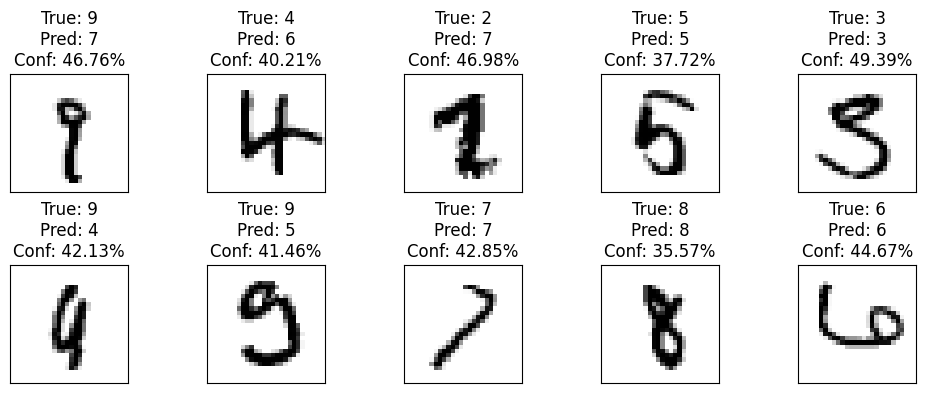

In [124]:
# Find uncertain predictions
low_conf_cases = (confidences < 0.5).nonzero(as_tuple=True)[0]

# Visualize 10 cases
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, idx in enumerate(low_conf_cases[:10]):
    ax = axes.flat[i]
    ax.imshow(test_dataset.data[idx].squeeze(), cmap='gray_r')
    ax.set_title(f'True: {test_dataset.targets[idx].item()}\n'
                 f'Pred: {pred_labels[idx].item()}\n'
                 f'Conf: {confidences[idx]*100:.2f}%')
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

In this image, the model predictions are associated with much lower confidence scores, generally between 35% and 49%. These low-confidence predictions indicate uncertainty, where the model hesitates between multiple classes. These ambiguous cases likely occur because the input images are less clear.

Finally, here is an overview of 25 misclassified examples.

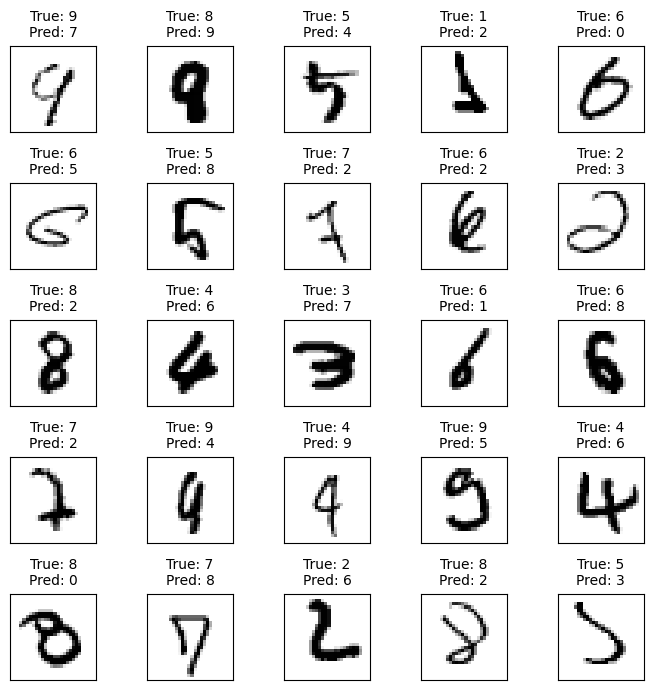

In [125]:
predicted_labels = torch.argmax(final_preds, dim=1)

# Find misclassified samples
misclassified_idx = (predicted_labels != test_dataset.targets) \
                    .nonzero(as_tuple=True)[0]
misclassified_images = test_dataset.data[misclassified_idx]
misclassified_labels = test_dataset.targets[misclassified_idx]
misclassified_preds = predicted_labels[misclassified_idx]

# Select 25 misclassified samples
num_samples = min(25, len(misclassified_idx))
misclassified_images = misclassified_images[num_samples:]
misclassified_labels = misclassified_labels[num_samples:]
misclassified_preds = misclassified_preds[num_samples:]

# Plot the misclassified samples
fig, axes = plt.subplots(5, 5, figsize=(7, 7))

for i, ax in enumerate(axes.flat):
    ax.imshow(misclassified_images[i], cmap='gray_r')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(
        f'True: {misclassified_labels[i].item()}\n'
        f'Pred: {misclassified_preds[i].item()}',
        fontsize=10
    )
plt.tight_layout()
plt.show()

**Some observations**:
-  Exploring different results (the first 25, the last 25, etc.), there are confusions that are repeated.  Several instances show a '3' being predicted as an '8', and vice versa. This is understandable, as the shapes are quite similar, especially if the '3' is written with a closed top or the '8' is slightly distorted.
-  Other misclassifications: There are other scattered errors, such as a '0' predicted as a '6', or a general confusion between the '7' and the '2'. These suggest that the model is sometimes struggling with digits that have similar overall shapes or when the writing style is unusual.
-  As we saw earlier, the MNIST dataset contains handwritten digits, which naturally vary in style, thickness, and completeness. These variations can make it challenging for the model to generalize perfectly.
-  Some images might be noisy, blurry, or have missing pixels, which can further hinder accurate classification.
-  The current model architecture might not be complex enough to capture all the nuances.

Lastly, we'll proceed with the visualization of weights to peek into the "black box" of the neural network and understand how it processes the images.

The first layer of the network, which directly interacts with the input image, has weights that can be visualized as images themselves. Each neuron in this layer will have a weight for every pixel, so visualizing these weights will help us see what patterns or features the neurons are detecting.

By visualizing these weights, we can see the patterns the model is trying to detect in the input.

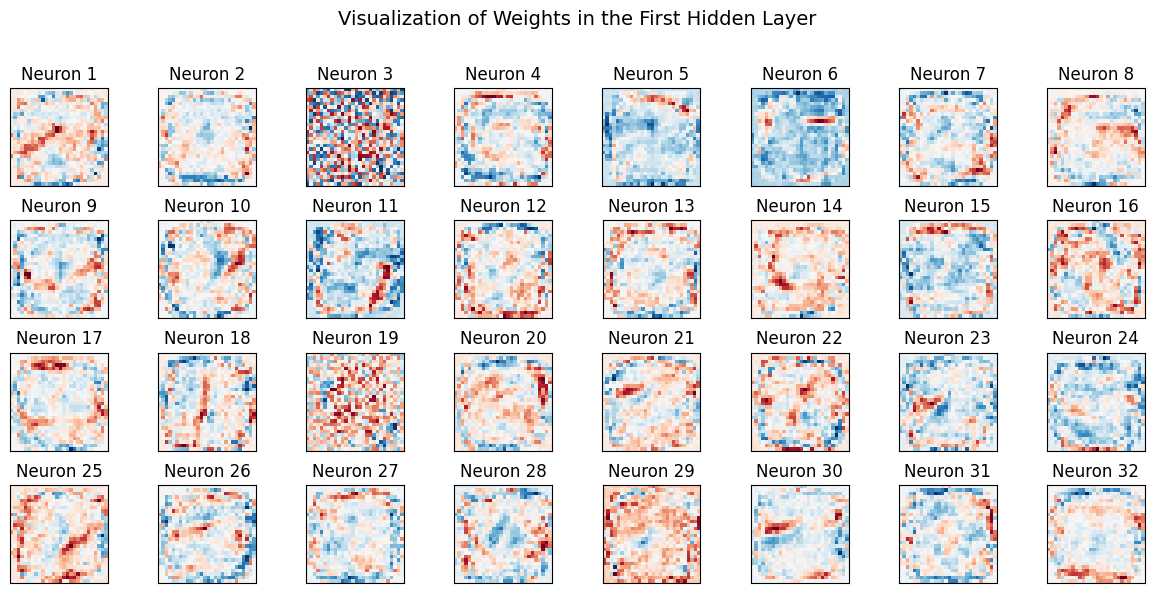

In [126]:
# Extract weights from the first hidden layer
weights = model.hidden1.weight.data #-- shape: [32, 784]

# Reshape the weights into 28x28 for visualization
weights = weights.view(-1, 28, 28) #-- shape: [32, 28, 28]

# Plot the weights as images
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
fig.suptitle('Visualization of Weights in the First Hidden Layer', fontsize=14)

for i, ax in enumerate(axes.flat):
    if i < weights.shape[0]:
        ax.imshow(weights[i], cmap='RdBu') #-- better than gray
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(f'Neuron {i+1}')
    else:
        ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In the code above, I extracted the weights of the first hidden layer and reshaped them into 28x28 pixel grids. Each weight grid corresponds to a neuron in the hidden layer, visualized as an image. These "images" give us an idea of the features or patterns that each neuron is trying to detect.

What we are seeing here is a grid of 32 different neurons (numbered 1-32), and each one shows a learned weight pattern that connects to every pixel in the input image. These patterns essentially represent what features each neuron has learned to detect. We can distinguish between positive weights (shown in red) and negative weights (shown in blue), while neutral weights appear white.

-  Red areas indicate positive weights: when pixels in these regions are activated, they increase the neuron's activations.
-  Blue areas indicate negative weights: when pixels in these regions are activated, they decrease the neuron's activation.
-  White areas indicate weights close to zero: these regions have minimal impact on the neuron's decision.

Neuron 29 shows a strong positive (red) pattern across most of its field, suggesting it might be looking for overall presence of ink or strokes in the image. This could be particularly useful for distinguishing between digits with many strokes (like 8) versus simpler digits (like 1).

Some neurons (like 5 and 6) show predominantly negative (blue) patterns, suggesting they might act as inhibitory neurons, helping to suppress certain features when they don't match expected patterns (in red).

Other neurons, like 1 and 11, show distinct diagonal patterns with opposing colors. This suggests they're looking for specific stroke orientations—activating strongly when strokes appear in one direction while suppressing responses to strokes in other directions.

Notice how the patterns in neurons like 6 and 30 are more subtle, with lighter colors overall. These neurons might be playing a more nuanced role in the network's decision-making process, perhaps helping to fine-tune the classifications.

Looking at neuron 3, we can notice something quite interesting and different from the other neurons: it shows a very noisy, checkerboard-like pattern with strong alternating positive and negative weights distributed somehwhat randomly across its field. This pattern is particularly distinctive because, unlike many other neurons that show more structured or smooth patterns, this one appears to have learned a very high-frequency pattern. This neuron might be acting as a kind of "noise detection", or it could be a "dead" or poorly optimized neuron (one that hasn't learned a meaningful feature pattern during training).

What's particularly fascinating is that these patterns emerged through training -they weren't explicitly programmed. The network discovered these features as the most useful ones for distinguishing between different digits. This is a great example of how neural networks learn to break down complex patterns into simpler, detectable features.

---
## **Model Improvements**

It's clear that there's always room for improvement when working with machine learning models. While the fully connected network performed admirably, achieving over 96% accuracy on the test set, it's worth considering some potential enhancements to push the model's performance even further.

One obvious avenue is exploring **Convolutional Neural Networks (CNNs)**, which I'll explore in future works. Another improvement we could consider is **hyperparameter tuning**, since the performance of a neural network heavily depends on factors like learning rate, batch size, and the number of neurons in each layer. Lastly, **data augmentation** could remain a powerful tool for enhancing model robustness. Techniques like random rotations, flips, and shifts can help the model generalize better by exposing it to a wider variety of samples.

---
## **References**

-  *Machine Learning with PyTorch and Scikit-Learn (ISBN-10: 1801819319 ISBN-13: 978-1801819312)*
-  Neural Networks playlist by **3Blue1Brown**: https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&si=D4MUW2dqb59NcMym
-  PyTorch links:    
    -  Web: https://pytorch.org/
    -  Torchvision docs: https://pytorch.org/vision/stable/index.html
    -  MNIST Dataset: https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html